/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Both `num_inference_steps`: 1 and `timesteps`: [0] are supplied; `timesteps` will be used over `num_inference_steps`.


  0%|          | 0/1 [00:00<?, ?it/s]

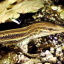

In [1]:
import torch
from diffusers import ConsistencyModelPipeline

device = "cuda"
model_id_or_path = "openai/diffusers-cd_imagenet64_l2"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.to(device)

#pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

# Multistep sampling
# Timesteps can be explicitly specified; the particular timesteps below are from the original GitHub repo:
# https://github.com/openai/consistency_models/blob/main/scripts/launch.sh#L83
image = pipe(timesteps=[0]).images[0]
image

## Consistency Model Pipeline

In [2]:
generator = torch.Generator(device=device)

In [3]:
generator.device.type

'cuda'

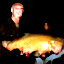

In [49]:
timesteps = [0]
generator = None
with torch.no_grad():
    batch_size=1
    img_size=pipe.unet.config.sample_size
    
    sample = pipe.prepare_latents(
                batch_size=batch_size,
                num_channels=pipe.unet.config.in_channels,
                height=img_size,
                width=img_size,
                dtype=pipe.unet.dtype,
                device=device,
                generator=generator,
                latents=None,
            )
    
    
    pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
    timesteps = pipe.scheduler.timesteps

    
    for t in timesteps:
        
        scaled_sample = pipe.scheduler.scale_model_input(sample, t)
        model_output = pipe.unet(
            scaled_sample, 
            t, 
            class_labels=torch.tensor([0], device=device), 
            return_dict=False
        )[0]

        output = pipe.postprocess_image(model_output)
    
        sample = pipe.scheduler.step(model_output, t, sample, generator=generator)[0]
    
    image = pipe.postprocess_image(sample)

output[0]

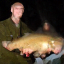

In [50]:
image[0]

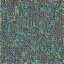

In [60]:
timesteps = [5]

from torch.autograd.functional import jacobian

with torch.no_grad():
    batch_size=1
    img_size=pipe.unet.config.sample_size
    generator=None
    
    sample = pipe.prepare_latents(
                batch_size=batch_size,
                num_channels=pipe.unet.config.in_channels,
                height=img_size,
                width=img_size,
                dtype=pipe.unet.dtype,
                device=device,
                generator=None,
                latents=None,
            )
    
    
    pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
    timesteps = pipe.scheduler.timesteps
    
    for t in timesteps:
       
        def run_pipeline(sample):
        
            scaled_sample = pipe.scheduler.scale_model_input(sample, t)
            
            model_output = pipe.unet(
                scaled_sample, 
                t, 
                class_labels=torch.tensor([0], device=device), 
                return_dict=False
            )[0]

            #sample = pipe.scheduler.step(model_output, t, sample, generator=generator)[0]

            #return sample
            return model_output

        def run_pipeline_vectorized(v):
            sample = torch.reshape(v, (1, 3, img_size, img_size))
            sample = run_pipeline(sample)
            return torch.reshape(sample, (3*img_size*img_size,))

        model_output = run_pipeline(sample)


        v = torch.reshape(sample, (3*img_size*img_size,))

        J = jacobian(run_pipeline_vectorized, inputs=v)

        #sample = run_pipeline_vectorized(v)

        #sample = torch.reshape(sample, (1,3,img_size,img_size))

        sample = pipe.scheduler.step(model_output, t, sample, generator=generator)[0]

    image = pipe.postprocess_image(sample)

image[0]

In [61]:
J = J.to(torch.float32)

In [62]:
svd = torch.svd(J)

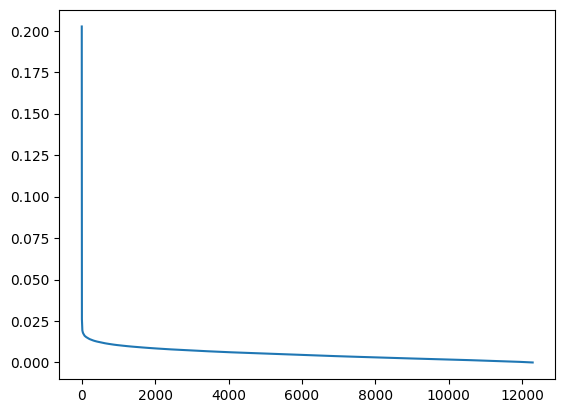

In [63]:
import matplotlib.pyplot as plt

U = svd.U.detach().cpu().numpy()
S = svd.S.detach().cpu().numpy()
V = svd.V.detach().cpu().numpy()

plt.plot(S)

plt.savefig(f"Jacobian_CD_{timesteps[0]}.jpg", dpi=300)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(S)

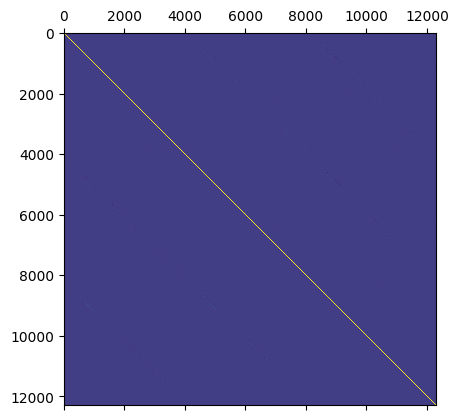

In [128]:
plt.matshow(U @ np.transpose(V))

In [117]:
torch.trace(J)

tensor(10.9007, device='cuda:0')

In [121]:
import numpy as np
np.sum(S*S)**0.5 / np.abs(S[0])

np.float32(1.5427604)

started 0
ended 0
started 1
ended 1
started 2
ended 2
started 3
ended 3
started 4
ended 4
started 5
ended 5
started 6
ended 6
started 7
ended 7


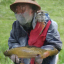

In [128]:
#timesteps = [10, 0]

timesteps = list(reversed(range(0, 40, 5)))

jac_idx = range(len(timesteps))
#jac_idx= []


from torch.autograd.functional import jacobian

samples = []

with torch.no_grad():
    batch_size=1
    img_size=pipe.unet.config.sample_size
    generator=None
    
    sample = pipe.prepare_latents(
                batch_size=batch_size,
                num_channels=pipe.unet.config.in_channels,
                height=img_size,
                width=img_size,
                dtype=pipe.unet.dtype,
                device=device,
                generator=None,
                latents=None,
            )
    
    
    pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
    timesteps = pipe.scheduler.timesteps
    
    for k, t in enumerate(timesteps):
       
        def run_pipeline(sample):        
            
            scaled_sample = pipe.scheduler.scale_model_input(sample, t)
            
            model_output = pipe.unet(
                scaled_sample, 
                t, 
                class_labels=torch.tensor([0], device=device), 
                return_dict=False
            )[0]
            
            sample = pipe.scheduler.step(model_output, t, sample, generator=generator)[0]

            return sample

        def run_pipeline_vectorized(v):
            sample = torch.reshape(v, (1, 3, img_size, img_size))
            sample = run_pipeline(sample)
            return torch.reshape(sample, (3*img_size*img_size,))

        sample = run_pipeline(sample)

        torch.save(sample.detach(), f"cm_saves/jul17/sample_{k}")

        samples += [sample]

        print(f"started {k}")
        if k in jac_idx:
            pipe.scheduler._step_index = pipe.scheduler._step_index - 1
            J_k = jacobian(run_pipeline_vectorized, inputs=v)
            torch.save(J_k.detach(), f"cm_saves/jul17/J_{k}_full_pipeline")
        #else:
        #    sample = run_pipeline(sample)
        print(f"ended {k}")
    
    image = pipe.postprocess_image(sample)

image[0]

In [155]:
pipe.scheduler.sigmas

tensor([8.0000e+01, 3.8266e+01, 1.6780e+01, 6.5901e+00, 2.2404e+00, 6.2540e-01,
        1.3120e-01, 1.7522e-02, 2.0000e-03])

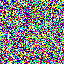

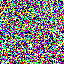

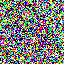

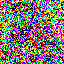

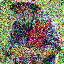

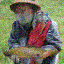

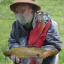

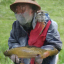

[None, None, None, None, None, None, None, None]

In [132]:
samples = [pipe.postprocess_image(torch.load(f"cm_saves/jul17/sample_{k}"))[0] for k in range(8)]
[display(s) for s in samples]

In [162]:
Jacobians = [torch.load(f"cm_saves/jul17/J_{k}_full_pipeline") for k in range(8)]
traces = [torch.trace(Jac).cpu().numpy() for Jac in Jacobians]
traces_normalized = [traces[k] / pipe.scheduler.sigmas[k] for k in range(8)]
traces

[array(20.92, dtype=float16),
 array(29.75, dtype=float16),
 array(56.47, dtype=float16),
 array(88.06, dtype=float16),
 array(119.2, dtype=float16),
 array(130.5, dtype=float16),
 array(126.56, dtype=float16),
 array(126.9, dtype=float16)]

Text(0, 0.5, 'Jacobian trace')

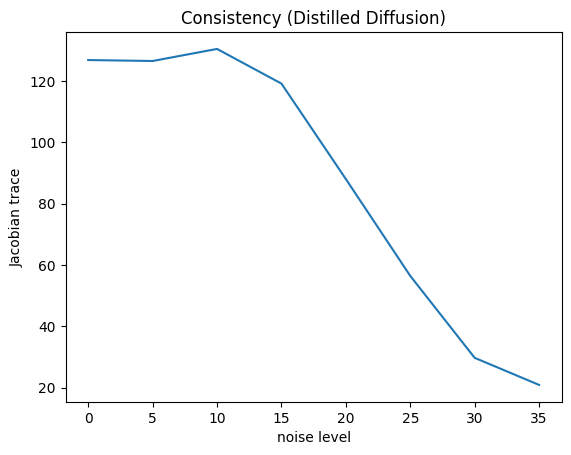

In [163]:
plt.plot(list(reversed(range(0, 40, 5))), traces)
#plt.plot(list(reversed(range(0, 40, 5))), traces_normalized)

plt.title("Consistency (Distilled Diffusion)")
plt.xlabel("noise level")
plt.ylabel("Jacobian trace")

Text(0, 0.5, 'bias, $|| x_t - x_0||$')

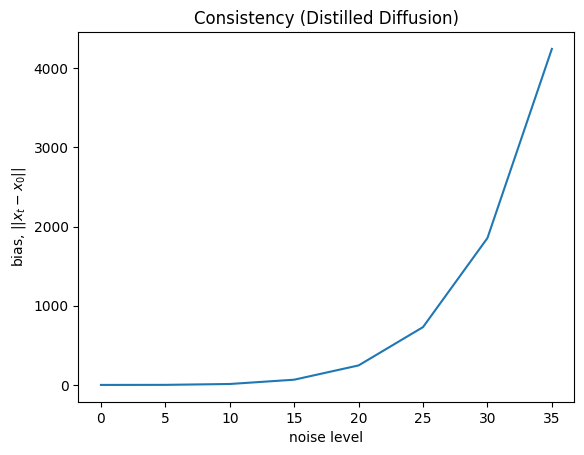

In [168]:
samples_tensor = [torch.load(f"cm_saves/jul17/sample_{k}")[0] for k in range(8)]
dtf = [torch.norm(samples_tensor[k] - samples_tensor[-1]).cpu() for k in range(8)]
dtf_normalized = [dtf[k] / pipe.scheduler.sigmas[k] for k in range(8)]
plt.plot(list(reversed(range(0, 40, 5))), dtf)
#plt.plot(list(reversed(range(0, 40, 5))), dtf_normalized)


plt.title("Consistency (Distilled Diffusion)")
plt.xlabel("noise level")
plt.ylabel("bias, $|| x_t - x_0||$")

## NO SCHEDULER STEP JACOBIANS

In [129]:
samples = [pipe.postprocess_image(torch.load(f"cm_saves/jul17/sample_{k}"))[0] for k in range(8)]

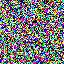

In [93]:
samples[2]

In [123]:
J_k = J_k.to(torch.float32)

In [124]:
svd_k = torch.svd(J_k)

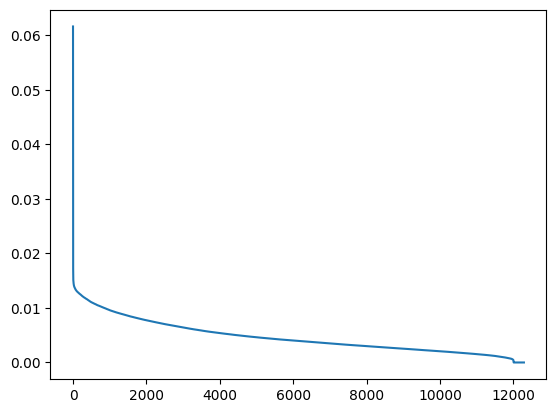

In [125]:
plt.plot(svd_k.S.detach().cpu())

started 0
ended 0
started 1
ended 1
started 2
ended 2
started 3
ended 3
started 4
ended 4
started 5
ended 5
started 6
ended 6
started 7
ended 7


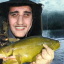

In [118]:
#timesteps = [10, 0]

timesteps = list(reversed(range(0, 40, 5)))

#jac_idx = range(len(timestep))
jac_idx= []


from torch.autograd.functional import jacobian

samples = []

with torch.no_grad():
    batch_size=1
    img_size=pipe.unet.config.sample_size
    generator=None
    
    sample = pipe.prepare_latents(
                batch_size=batch_size,
                num_channels=pipe.unet.config.in_channels,
                height=img_size,
                width=img_size,
                dtype=pipe.unet.dtype,
                device=device,
                generator=None,
                latents=None,
            )
    
    
    pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
    timesteps = pipe.scheduler.timesteps
    
    for k, t in enumerate(timesteps):
       
        def run_pipeline(sample):
        
            scaled_sample = pipe.scheduler.scale_model_input(sample, t)
            
            model_output = pipe.unet(
                scaled_sample, 
                t, 
                class_labels=torch.tensor([0], device=device), 
                return_dict=False
            )[0]

            #sample = pipe.scheduler.step(model_output, t, sample, generator=generator)[0]

            #return sample
            return model_output

        

        def run_pipeline_vectorized(v):
            sample = torch.reshape(v, (1, 3, img_size, img_size))
            sample = run_pipeline(sample)
            return torch.reshape(sample, (3*img_size*img_size,))

        model_output = run_pipeline(sample)

        torch.save(model_output.detach(), f"cm_saves/jul17/output_{k}")

        sample = pipe.scheduler.step(model_output, t, sample, generator=generator)[0]

        torch.save(sample.detach(), f"cm_saves/jul17/sample_{k}")

        
        samples += [sample]

        print(f"started {k}")
        if k in jac_idx:
            pipe.scheduler._step_index = pipe.scheduler._step_index - 1
            J_k = jacobian(run_pipeline_vectorized, inputs=v)
            torch.save(J_k.detach(), f"cm_saves/jul17/J_{k}")
        #else:
        #    sample = run_pipeline(sample)
        print(f"ended {k}")
    
    image = pipe.postprocess_image(sample)

image[0]

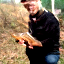

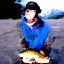

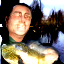

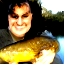

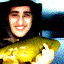

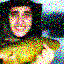

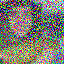

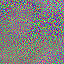

[None, None, None, None, None, None, None, None]

In [130]:
outputs = [pipe.postprocess_image(torch.load(f"cm_saves/jul17/output_{k}"))[0] for k in range(8)]
[display(s) for s in outputs]

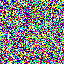

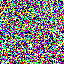

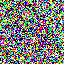

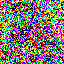

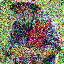

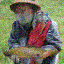

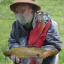

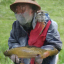

[None, None, None, None, None, None, None, None]

In [131]:
samples = [pipe.postprocess_image(torch.load(f"cm_saves/jul17/sample_{k}"))[0] for k in range(8)]
[display(s) for s in samples]